# Importing and formatting the coordinate data

Import and preview the data

In [10]:
import numpy as np
import pandas as pd

# Import knee coordinates
coords_file = pd.read_excel("../data/198_218 updated xy coordinates for knee-aging 250426.xlsx", engine='openpyxl', sheet_name=None) # More updated Excel import
# coords_file = pd.read_excel("../data/xy coordinates for knee-aging three cycles 250303.xlsx", engine='openpyxl', sheet_name=None) # More updated Excel import
# coords_file = pd.read_excel("../data/adjusted xy coordinates for knee-aging 250403.xlsx", engine='openpyxl', sheet_name=None) # More updated Excel import

# Select data set
knee_idx = 2
cf_keys = ['aging-1', 'aging-2', 'aging-3']
coords_sheet = coords_file[cf_keys[knee_idx]] # Set index = {0,1,2} to choose different data set

# Clean data
coords_sheet.drop(columns=['Unnamed: 0', 'Unnamed: 5'], axis=1, inplace=True) # No information

valid_coords_1 = (coords_sheet['Frame Number'].notna() | coords_sheet['X'].notna() | coords_sheet['Y'].notna())
valid_coords_2 = (coords_sheet['Frame Number.1'].notna() | coords_sheet['X'].notna() | coords_sheet['Y'].notna())

coords_1 = coords_sheet[['Frame Number', 'X', 'Y']].loc[valid_coords_1]
coords_2 = coords_sheet[['Frame Number.1', 'X', 'Y']].loc[valid_coords_2]

# na_coords_1 = coords_sheet['Frame Number'].isna() & coords_sheet['X'].isna() & coords_sheet['Y'].isna() # What was I cooking
# na_coords_2 = coords_sheet['Frame Number.1'].isna() & coords_sheet['X.1'].isna() & coords_sheet['Y.1'].isna()

# coords_1 = coords_sheet[['Frame Number', 'X', 'Y']].loc[~na_coords_1]
# coords_2 = coords_sheet[['Frame Number.1', 'X.1', 'Y.1']].loc[~na_coords_2]

flx_to_ext = int(coords_2.iloc[0]['Frame Number.1']) # For later: get flexion/extension boundary

# 
coords_2.rename(columns={'Frame Number.1': 'Frame Number', 'X.1': 'X', 'Y.1': 'Y'}, inplace=True) 
coords = pd.concat([coords_1, coords_2], axis=0)

# Set new index for easier iterations
coords.set_index("Frame Number", inplace=True)
coords.index = coords.index.to_series().fillna(method="ffill").astype(int)

# Get unique frames
unique_frames = coords.index.unique()

# Segment and process the knee regions

Segment knee into three parts and get sum of pixel intensities

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'utils')) # Build an absolute path from this notebook's parent directory
if module_path not in sys.path: # Add to sys.path if not already present
    sys.path.append(module_path)
import numpy as np
import pandas as pd
import cv2
import tifffile as tiff
import utils

# Read image stack
aging_knee = tiff.imread("../data/1 aging_00000221.tif") # Imports image stack as np.ndarray (3 dimensions)
_, h, w = aging_knee.shape # Dimensions of video stack
aging_knee = np.concatenate( (np.zeros((1,h,w), dtype=np.uint8),aging_knee), axis=0) # Prepend blank frame -> 1-based indexing


# Get basic frame info
first_frame = unique_frames[0]
last_frame = unique_frames[-1]
curr_frame = first_frame

# Initialize data storage
knee_intensities = np.zeros((3, unique_frames.shape[0]))
knee_intensities_normalized = np.zeros((3, unique_frames.shape[0]))
knee_total_areas = np.zeros((3, unique_frames.shape[0])) # Save total area of each mask 

In [5]:


while curr_frame <= last_frame:

    # Get frame
    frame = aging_knee[curr_frame, :, :].copy() # true copy

    # Pre-processing
    frame, translation_mx = utils.centroid_stabilization(frame) # Center the frame based on the 

    'Coordinates plotting'

    # Get coordinates to be plotted
    curr_f_coords = coords.loc[curr_frame]

    # Transform coordinates according to centroid stabilization
    curr_f_coords = np.column_stack([curr_f_coords.to_numpy(), np.ones(curr_f_coords.shape[0])])
    curr_f_coords = (translation_mx @ curr_f_coords.T).T[:, 0:2]

    # Store coordinates as integer tuples
    point_coords = [tuple(curr_f_coords[pt_n].astype(int)) for pt_n in range(4)]

    # Plot points
    for x, y in point_coords:
        cv2.circle(frame, (x, y), 3, [255, 255, 255], -1)

    # Draw lines between points 0-1 and 2-3
    cv2.line(frame, point_coords[0], point_coords[1], [255, 255, 255], 1)
    cv2.line(frame, point_coords[2], point_coords[3], [255, 255, 255], 1)
#     cv2.circle(frame, point_coords[3], 3, [255, 255, 255], -1)


    # Draw line between left and right region
    midpoints = [
    ((point_coords[0][0] + point_coords[2][0]) // 2, (point_coords[0][1] + point_coords[2][1]) // 2),
    ((point_coords[1][0] + point_coords[3][0]) // 2, (point_coords[1][1] + point_coords[3][1]) // 2)
    ]
    # cv2.line(frame, midpoints[0], midpoints[1], [255,0,0], 1)


    'Three-parts segmentation'

    # Get left/right mask based on the middle line
    left_right_mask = utils.pixels_left_of_line(frame, midpoints[1], midpoints[0])
    left_right_mask = utils.crop_square_frame(left_right_mask, 350) # For ease of viewing

    # Get middle mask between the left and right lines
    left_mask = utils.pixels_left_of_line(frame, point_coords[1], point_coords[0])
    right_mask = utils.pixels_left_of_line(frame, point_coords[2], point_coords[3])
    left_mask = utils.crop_square_frame(left_mask, 350) # For ease of viewing
    right_mask = utils.crop_square_frame(right_mask, 350) # For ease of viewing
    middle_mask = ~left_mask & ~right_mask

    # Get Otsu's mask
    thresh_val, _ = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh_val = int(thresh_val*0.8)
    _, otsu_mask = cv2.threshold(frame, thresh_val, 255, cv2.THRESH_BINARY)
    otsu_mask = utils.crop_square_frame(otsu_mask, 350) # For ease of viewing

    # Get knee masks
    middle_knee_mask = otsu_mask & middle_mask
    left_knee_mask = otsu_mask & left_right_mask & ~middle_mask #& left_mask
    right_knee_mask = otsu_mask & ~left_right_mask & ~middle_mask #& right_mask

    # Crop frame to square region [TODO: do this before the other operations?]
    frame = utils.crop_square_frame(frame, 350) # For ease of viewing

    # Resize frame for easier viewing
    pixel_scale = 10.1119 # pixels / mm
    # frame, scaling_factor = utils.rescale_frame(frame, pixel_scale, 0)

    'Get sum of pixel intensities in each part'
    
    # Get left/middle/right knee
    left_knee = frame & left_knee_mask
    middle_knee = frame & middle_knee_mask
    right_knee = frame & right_knee_mask

    # Get total number of non-zero pixels
    left_knee_nonzero = np.sum(left_knee_mask)
    middle_knee_nonzero = np.sum(middle_knee_mask)
    right_knee_nonzero = np.sum(right_knee_mask)

    # Get normalized left/middle/right knee pixel intensities
    curr_idx = curr_frame - first_frame
    MODIFY_DATA = True # === OPTIONAL: flag to overwrite recorded data ===
    if MODIFY_DATA:
        knee_intensities[0, curr_idx] = np.sum(left_knee) # left intensity
        knee_intensities[1, curr_idx] = np.sum(middle_knee) # middle intensity
        knee_intensities[2, curr_idx] = np.sum(right_knee) # right intensity

        knee_intensities_normalized[0, curr_idx] = np.sum(left_knee) / left_knee_nonzero # left intensity
        knee_intensities_normalized[1, curr_idx] = np.sum(middle_knee) / middle_knee_nonzero # middle intensity
        knee_intensities_normalized[2, curr_idx] = np.sum(right_knee) /right_knee_nonzero # right intensity    

        knee_total_areas[0, curr_idx] = np.sum(left_knee_nonzero) # left mask sum
        knee_total_areas[1, curr_idx] = np.sum(middle_knee_nonzero) # middle mask sum
        knee_total_areas[2, curr_idx] = np.sum(right_knee_nonzero) # right mask sum


    'Display frames and information'

    # --- For demonstration: overlay the masks on the frame ---
    # frame = np.maximum.reduce([frame, left_knee_mask, middle_knee_mask, right_knee_mask])

    # Show knee_mask, to verify boundaries and such
    knee_mask = np.maximum.reduce([left_knee, middle_knee, right_knee])

    # Write frame number in bottom left corner of knee_mask
    h,w = knee_mask.shape
    pos = (10, h - 10)
    cv2.putText(knee_mask, str(curr_frame), pos, 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, 
                color = (255,255,255), thickness = 2, lineType = cv2.LINE_AA)
    cv2.imshow(f"knee_mask, frames {first_frame} to {last_frame}", knee_mask) # Display knee_mask

    # Write coordinates in top-left corner 
    # TODO: print the original points and not the transformed coordinates!! 
    pos1 = (int(3*w//4), 15)
    lines = [tuple(coords.loc[curr_frame].iloc[i].astype(int)) for i in range(0,4)]
    cv2.putText(knee_mask, f"l line: {lines[0]}", pos1, 
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.3, 
            color = (255,255,255), thickness = 1, lineType = cv2.LINE_AA)
    pos2 = (int(3*w//4), 30)
    cv2.putText(knee_mask, f"       {lines[1]}", pos2, 
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.3, 
            color = (255,255,255), thickness = 1, lineType = cv2.LINE_AA)
    pos3 = (int(3*w//4), 45)
    cv2.putText(knee_mask, f"r line: {lines[2]}", pos3, 
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.3, 
            color = (255,255,255), thickness = 1, lineType = cv2.LINE_AA)
    pos4 = (int(3*w//4), 60)
    cv2.putText(knee_mask, f"       {lines[3]}", pos4, 
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.3, 
            color = (255,255,255), thickness = 1, lineType = cv2.LINE_AA)


    # Show other masks, for correctness
    check_frame = left_knee_mask & middle_knee_mask # Check for intersections of different masks (should be empty)
    # cv2.imshow("left_knee_mask", left_knee_mask)
    # cv2.imshow("middle_knee_mask", middle_knee_mask)
    # cv2.imshow("right_knee_mask", right_knee_mask)
    # cv2.imshow("check_frame", check_frame)
    # cv2.imshow("whole_mask", np.maximum.reduce([left_knee_mask, middle_knee_mask, right_knee_mask]))

    # Show frame
    cv2.imshow(f"aging knee frames {first_frame} - {last_frame}", frame)

    # Display enlarged frame
    enlarged_frame = frame.copy()
    pixel_scale = 10.1119 # pixels / mm
    enlarged_frame, _ = utils.rescale_frame(frame, pixel_scale, 1.5)
#     cv2.imshow("enlarged frame", enlarged_frame)


    'Miscellaneous technical things'

    # TEMPORARY: knee_video frames for Dr. Liang to check correctness
    frame_out = cv2.hconcat([knee_mask, left_knee_mask, middle_knee_mask, right_knee_mask])
    cv2.imshow(f"{cf_keys[knee_idx]} knee (frames {first_frame}-{last_frame})", frame_out)

    # === Optionally generate figures ===
    GENERATE_FIGURES = True
    if GENERATE_FIGURES:
        fn = f"../figures/labeled {cf_keys[knee_idx]} frames/{cf_keys[knee_idx]}_{curr_frame:04d}.png"
        os.makedirs(os.path.dirname(fn), exist_ok=True)
        cv2.imwrite(fn, frame_out) 


    # Increment frame index
    curr_frame = curr_frame +1

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

    # Optionally LOOP video
    LOOP = False
    if LOOP and curr_frame > last_frame: 
        curr_frame = first_frame

cv2.destroyAllWindows()



In [6]:
for fn in np.arange(first_frame, last_frame + 1):

    print(f"{fn}: {knee_intensities[2][fn-first_frame]} / {knee_total_areas[2][fn-first_frame]}")
    # print(knee_intensities[0])

175: 493820.0 / 1160250.0
176: 475788.0 / 1098030.0
177: 477114.0 / 1092675.0
178: 462743.0 / 1084005.0
179: 483398.0 / 1153875.0
180: 447639.0 / 1082985.0
181: 447639.0 / 1082985.0
182: 465854.0 / 1158975.0
183: 464494.0 / 1162290.0
184: 488864.0 / 1204620.0
185: 485110.0 / 1195440.0
186: 477385.0 / 1191615.0
187: 508116.0 / 1264800.0
188: 511185.0 / 1270155.0
189: 521004.0 / 1297440.0
190: 502078.0 / 1270665.0
191: 490099.0 / 1252560.0
192: 504968.0 / 1352010.0
193: 508793.0 / 1349205.0
194: 531206.0 / 1416270.0
195: 510226.0 / 1345890.0
196: 515907.0 / 1333905.0
197: 521700.0 / 1358130.0
198: 518104.0 / 1371900.0
199: 484592.0 / 1253325.0
200: 525394.0 / 1376745.0
201: 514282.0 / 1322685.0
202: 541578.0 / 1415250.0
203: 501556.0 / 1206150.0
204: 503099.0 / 1182690.0
205: 521773.0 / 1250010.0
206: 511418.0 / 1206405.0
207: 511418.0 / 1206405.0
208: 529455.0 / 1262250.0
209: 520689.0 / 1250775.0
210: 522980.0 / 1239555.0
211: 512344.0 / 1206150.0
212: 524350.0 / 1239555.0
213: 531515.

Plot intensities (Normalized)

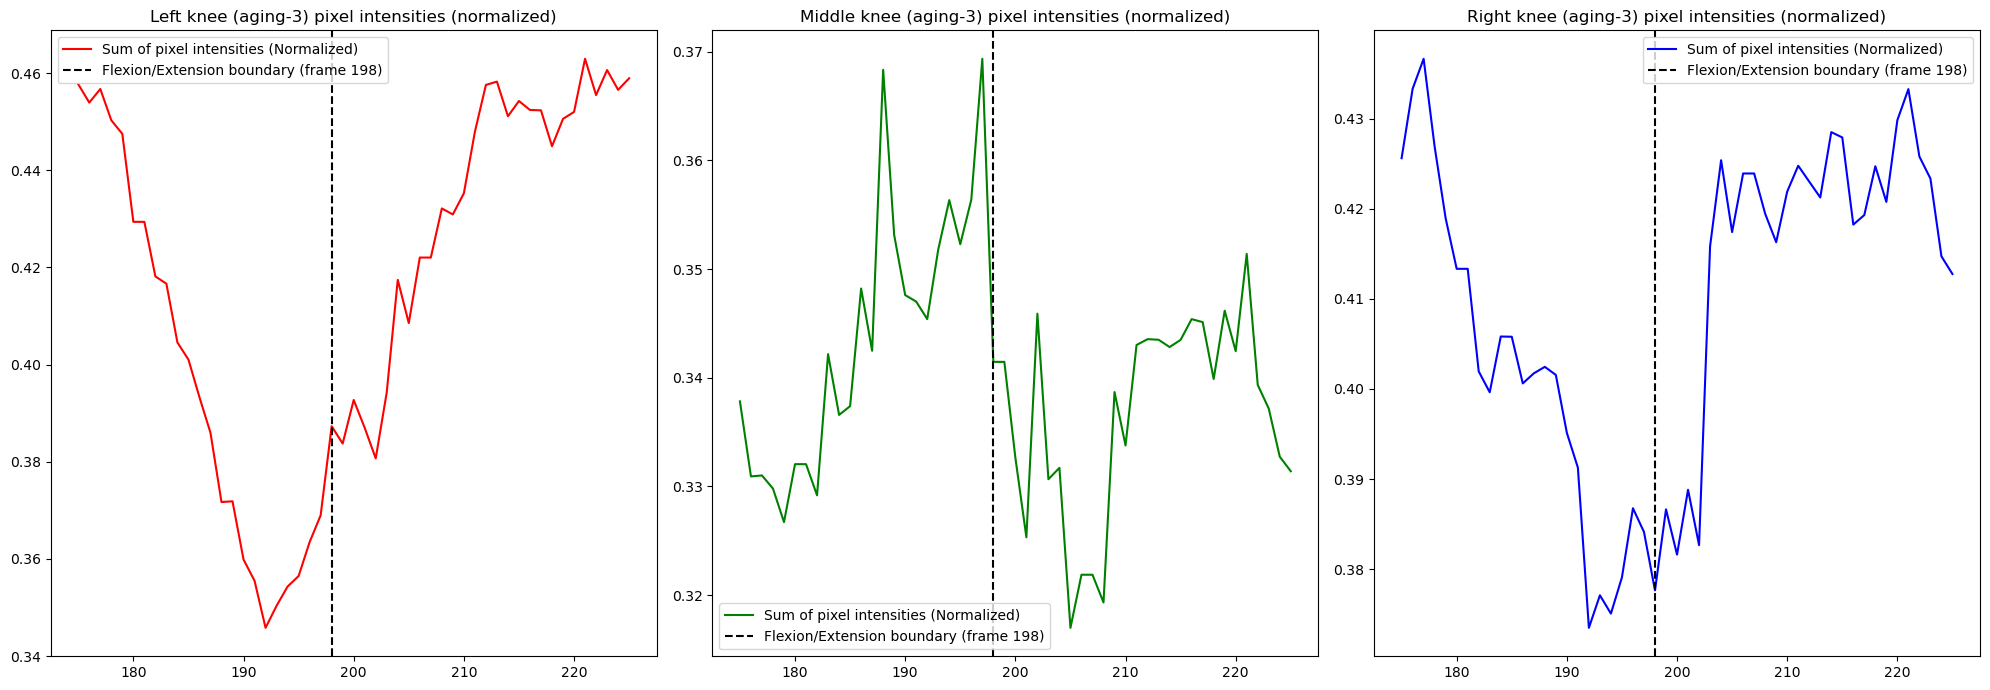

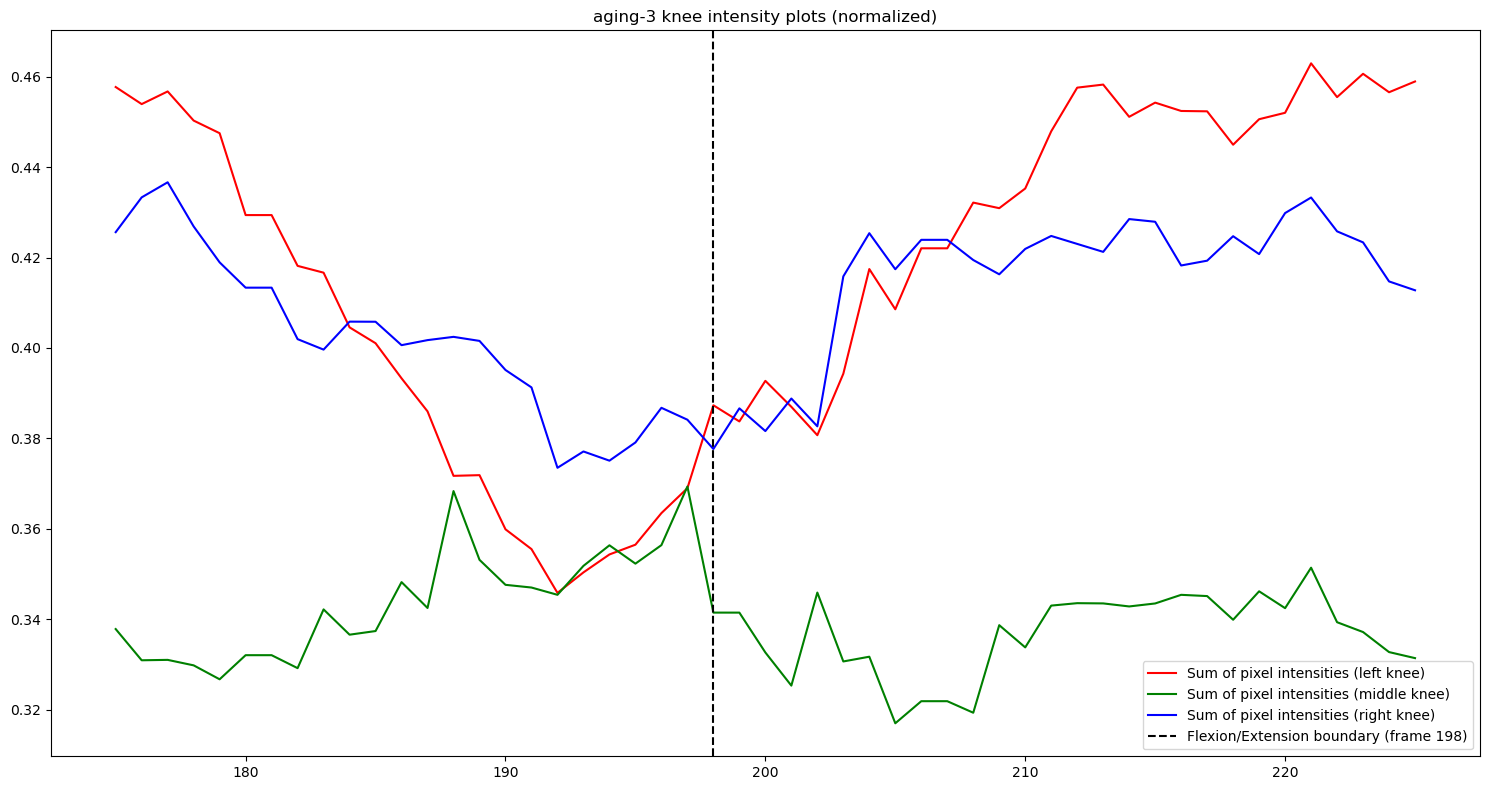

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')

# Create 3 plots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  

# Plot all three intensities
x_values = np.arange(unique_frames.shape[0]) + first_frame
axes[0].plot(x_values, knee_intensities_normalized[0, :], label="Sum of pixel intensities (Normalized)", color='r')
axes[1].plot(x_values, knee_intensities_normalized[1, :], label="Sum of pixel intensities (Normalized)", color='g')
axes[2].plot(x_values, knee_intensities_normalized[2, :], label="Sum of pixel intensities (Normalized)", color='b')

# --- Formatting ---
# Set titles
axes[0].set_title(f"Left knee ({cf_keys[knee_idx]}) pixel intensities (normalized)")
axes[1].set_title(f"Middle knee ({cf_keys[knee_idx]}) pixel intensities (normalized)")
axes[2].set_title(f"Right knee ({cf_keys[knee_idx]}) pixel intensities (normalized)")

# Draw flexion/extension line
flx_ext_pt = flx_to_ext # aging-1: 62, aging-2: 102, aging-3: 198
flx_ext_pt_adj = flx_ext_pt - first_frame # e.g. for aging-1, flexion ends at frame 61, extension starts at frame 62
axes[0].axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")
axes[1].axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")
axes[2].axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")

# Show legends
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Save the 3 side-by-side plot
plt.tight_layout()
fn = f"../figures/intensity_plots/normalized_separate_{cf_keys[knee_idx]}.png"
os.makedirs(os.path.dirname(fn), exist_ok=True)
plt.savefig(fn, dpi=300, bbox_inches="tight")

# Create plot with all three on the same plot 
plt.figure(figsize=(15,8))
plt.plot(x_values, knee_intensities_normalized[0, :], color = 'r', label="Sum of pixel intensities (left knee)")
plt.plot(x_values, knee_intensities_normalized[1, :], color = 'g', label="Sum of pixel intensities (middle knee)")
plt.plot(x_values, knee_intensities_normalized[2, :], color = 'b', label="Sum of pixel intensities (right knee)")
plt.axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")
plt.title(f"{cf_keys[knee_idx]} knee intensity plots (normalized)")

plt.legend()
plt.tight_layout()

fn = f"../figures/intensity_plots/normalized_combined_{cf_keys[knee_idx]}.png"
os.makedirs(os.path.dirname(fn), exist_ok=True)
plt.savefig(fn, dpi=300, bbox_inches="tight")

# Show the plots
plt.show()


Plot intensities (Not Normalized)

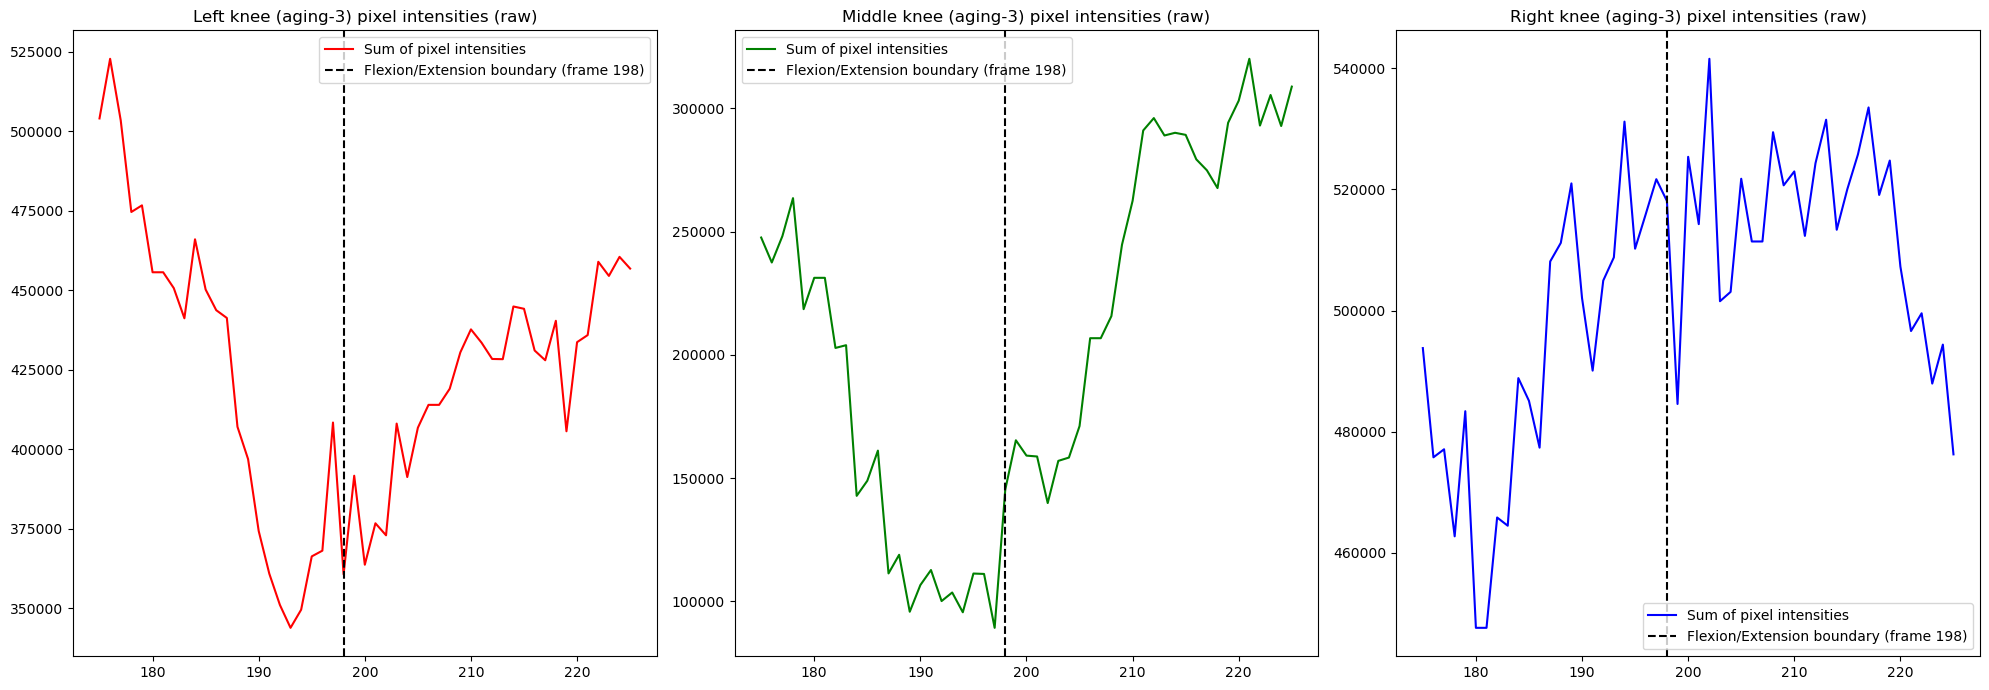

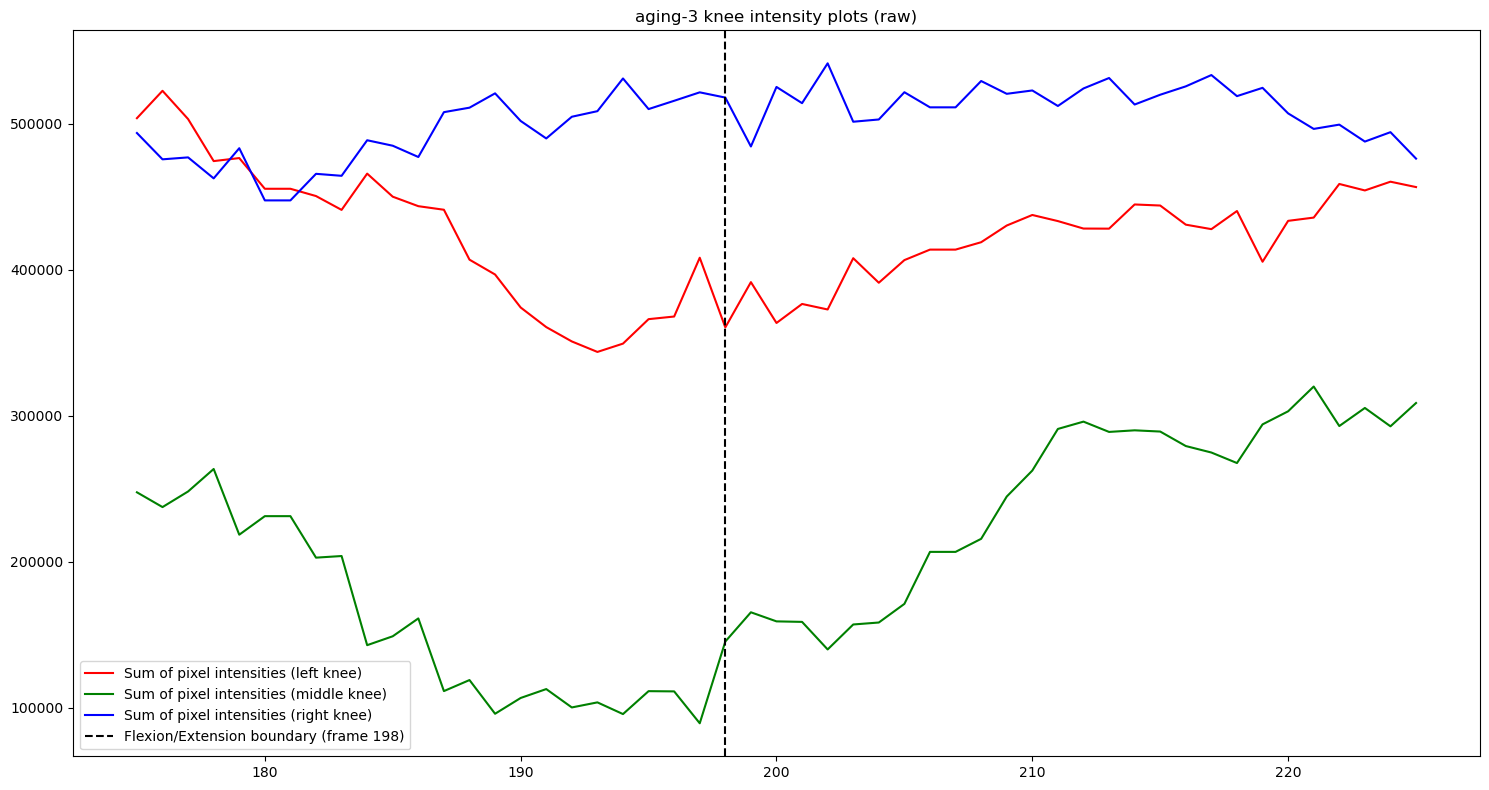

In [8]:
import matplotlib.pyplot as plt

plt.style.use('default')

# Create 3 plots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  

# Plot all three intensities
x_values = np.arange(unique_frames.shape[0]) + first_frame
axes[0].plot(x_values, knee_intensities[0, :], label="Sum of pixel intensities", color='r')
axes[1].plot(x_values, knee_intensities[1, :], label="Sum of pixel intensities", color='g')
axes[2].plot(x_values, knee_intensities[2, :], label="Sum of pixel intensities", color='b')

# --- Formatting ---
# Set titles
axes[0].set_title(f"Left knee ({cf_keys[knee_idx]}) pixel intensities (raw)")
axes[1].set_title(f"Middle knee ({cf_keys[knee_idx]}) pixel intensities (raw)")
axes[2].set_title(f"Right knee ({cf_keys[knee_idx]}) pixel intensities (raw)")

# Draw flexion/extension line
flx_ext_pt = 102 #aging-1: 62, aging-2: 102, aging-3: 198
flx_ext_pt_adj = flx_ext_pt - first_frame # e.g. for aging-1, flexion ends at frame 61, extension starts at frame 62
axes[0].axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")
axes[1].axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")
axes[2].axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")

# Show legends
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Save the 3 side-by-side plot
plt.tight_layout()
fn = f"../figures/intensity_plots/raw_separate_{cf_keys[knee_idx]}.png"
os.makedirs(os.path.dirname(fn), exist_ok=True)
plt.savefig(fn, dpi=300, bbox_inches="tight")

# Create plot with all three on the same plot 
plt.figure(figsize=(15,8))
plt.plot(x_values, knee_intensities[0, :], color = 'r', label="Sum of pixel intensities (left knee)");
plt.plot(x_values, knee_intensities[1, :], color = 'g', label="Sum of pixel intensities (middle knee)");
plt.plot(x_values, knee_intensities[2, :], color = 'b', label="Sum of pixel intensities (right knee)");
plt.axvline(flx_to_ext, color='k', linestyle='--', label=f"Flexion/Extension boundary (frame {flx_to_ext})")
plt.title(f"{cf_keys[knee_idx]} knee intensity plots (raw)")

plt.legend()
plt.tight_layout()

# Save plots
fn = f"../figures/intensity_plots/raw_combined_{cf_keys[knee_idx]}.png"
os.makedirs(os.path.dirname(fn), exist_ok=True)
plt.savefig(fn, dpi=300, bbox_inches="tight")

plt.show()


# Meeting Notes (24 Apr. 2025)
- Check aging-3 frame 198, 218 for correctness
- work on the other things

# Meeting Notes 14 Apr. 2025
- ~~focus on getting updated plots (fix the code using the new coordinates)~~
- ~~^ finish this, then we can meet (don't worry too much about stats project)~~
- then try to improve the femur estimation 

- for future:
- clarify the purpose of cutting the knee into N points 
    for them -> automated segmenting of knee into three parts (requires manual verification)
    for us -> detailed information needed for CFD model 

# Meeting Notes (7 Apr 2025)

- ~~**fix knee plotting coordinates** (incorrect indexing? some printed coordinates do not match up)~~
    - we want to help them feel convinced that collecting more data will be helpful
- generate plots and labeled frames and send to profs 

- calculate difference between $frame_{k+1} - frame_k$ -> **local approximation of rate of change**
    - do this on both the normal and aging knee -> need intensity plots for the normal knee as well 

- for future: add random noise -> simulate new data -> conduct statistical analysis to determine differences between different intensity plots?

# Meeting Notes (1 Apr 2025)
- Dr. Liang wants: 
- ~~sequence of images for each frame with the boundary drawn and lines separating the knee into three parts (only for aging-1 cycle)~~
- ~~(put frame number in the bottom left corner)~~
- **~~get intensity plots for all three cycles~~**
- ~~change the x-axis for the intensity plots to the absolute frame number (not relative frame number)~~



# Meeting Notes (31 Mar 2025)
- ~~make one plot for each cycle (aging-1, aging-2, aging-3)~~
- ~~improve plots by adding formatting things~~
- make plot of the average of each cycle? (maybe we need to ask if they want this, or just make it so they have the option)
- ~~make two versions of the plots: one of them is the current version (sum of pixel intensities), the other is normalized plot of pixel intensities (sum of pixel intensities / number of non-zero pixels)~~
- ~~add dashed v-line to show where the flexion and extension is~~
- after meeting: redo normal knee plot and compare with Juan's method
- ~~send Dr. Liang the aging-1 plot (with titles/labels/legend/v-line)~~

- for future: **work on cutting the old knee into the circle slices**
- consider doing statistical analysis to determine whether there is a meaningful difference between normal and aging knee? (maybe difficult)

# Meeting Notes (17 Mar 2025)
- ~~some frames have parallel lines -> maybe the original coordinates are not very accurate?~~
- ~~^ try to alter some coordinates to improve the parallel lines (make note of which coordinates we altered)~~
- ~~come up with fast results to demonstrate that we can do the analysis they want~~ 
- ~~get plot like Juan's because its clear -> ask him for details of his 3-parts analysis code?~~

- ~~try cutting the circle into N different slices, to also show that we can do the proposed analysis for the CFD model~~

# TODO:
- ~~get intensity **inside the boundary only**~~ 
- ~~this can be done by taking the intersection of the masks and the knee mask~~
- ~~send three parts intensity plot to Profs~~ 
- ~~then work on cutting the circle into N slices~~

~~program: "imageJ file" -> "imageJ file (centered)"~~ 